<h3>Import Necessary Packages</h3>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

<h3>Connect Google Drive with Colab</h3>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Minor Project Dataset.xlsx'
data = pd.ExcelFile(file_path)
continous_df = data.parse('Continious Values')

Mounted at /content/drive


<h2>Exploratory Data Analysis</h2>

<h3>Check the Total Number of Rows</h3>

In [ ]:
continous_df.shape

(115, 10)

<h3>Check the Total Number of Non-null Rows</h3>

In [ ]:
continous_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Step time           115 non-null    int64  
 1   Initial value       115 non-null    int64  
 2   Final value         115 non-null    int64  
 3   Sample time         115 non-null    int64  
 4   Proportional        115 non-null    int64  
 5   Integral            115 non-null    int64  
 6   Derivative          115 non-null    int64  
 7   Filter coefficient  115 non-null    int64  
 8   Output              115 non-null    int64  
 9   Confusion           0 non-null      float64
dtypes: float64(1), int64(9)
memory usage: 9.1 KB


<h3>Data is not linearly separable</h3>

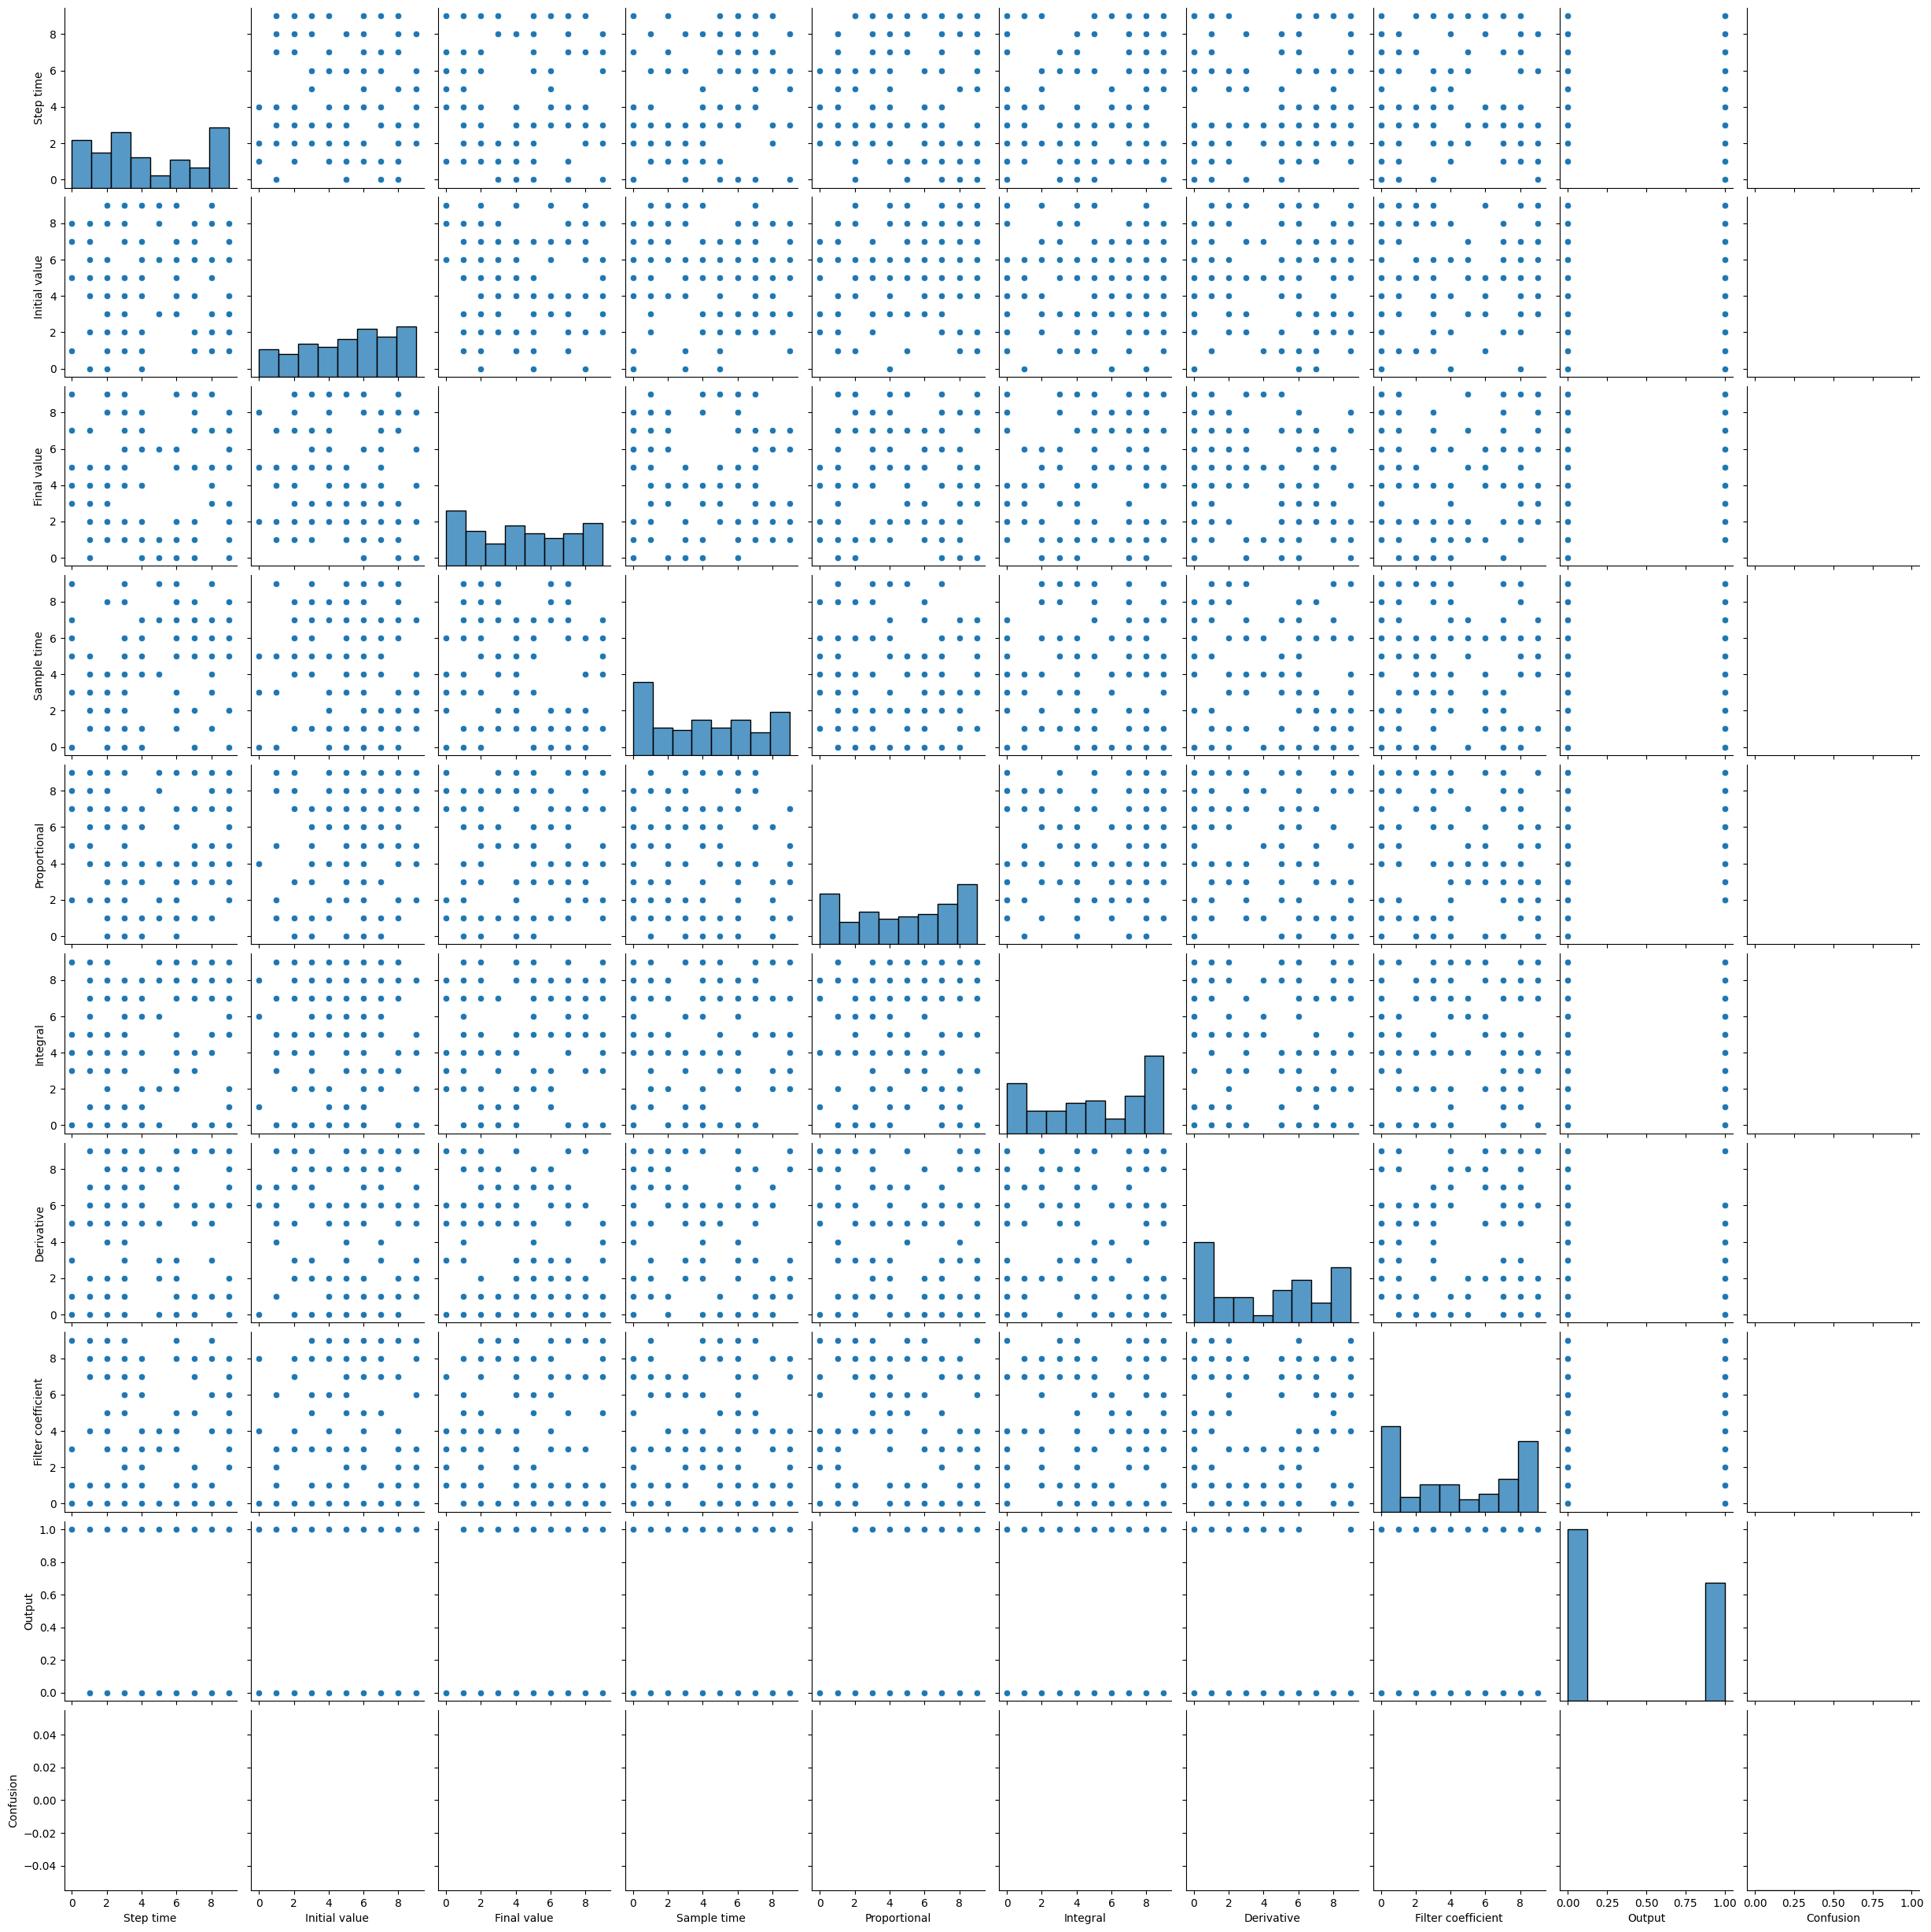

In [ ]:
sns.pairplot(continous_df)

<h2>Data Preprocessing</h2>

<h3>1. Remove the rows where output has confusion</h3>



In [ ]:
continous_df = continous_df[continous_df['Confusion'].isnull()]

In [ ]:
continous_df.drop(columns=['Confusion'], inplace=True)

<h5>Convert the Ouput Column from Float64 to Int64</h5>

In [ ]:
continous_df

,Step time,Initial value,Final value,Sample time,Proportional,Integral,Derivative,Filter coefficient,Output
0,9,6,6,0,8,1,0,8,1
1,9,6,6,0,8,1,0,8,1
2,2,6,8,2,3,0,1,7,1
3,9,7,2,0,5,5,9,0,0
4,7,7,7,0,3,8,1,7,1
...,...,...,...,...,...,...,...,...,...
110,8,2,5,6,8,7,3,0,1
111,2,4,8,2,8,8,0,3,1
112,0,1,7,0,2,0,5,0,1
113,9,6,8,2,7,5,1,7,1


In [ ]:
continous_df['Output'] = continous_df['Output'].astype('int64')
continous_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Step time           115 non-null    int64
 1   Initial value       115 non-null    int64
 2   Final value         115 non-null    int64
 3   Sample time         115 non-null    int64
 4   Proportional        115 non-null    int64
 5   Integral            115 non-null    int64
 6   Derivative          115 non-null    int64
 7   Filter coefficient  115 non-null    int64
 8   Output              115 non-null    int64
dtypes: int64(9)
memory usage: 8.2 KB


<h4>The class of 0 is 60% and 1 is 40%. It is imbalanced.</h4>



In [ ]:
continous_df['Output'].value_counts(normalize=True)

,proportion
Output,
0,0.591304
1,0.408696


<h4>1. Attempting Feature Selection</h4>

In [ ]:
continous_df = continous_df.drop(columns=["Sample time", "Filter coefficient"])

<h3>2. Split the data into Training and Testing Parts</h3>

In [ ]:
X = continous_df.drop(columns='Output', axis=1)
y = continous_df['Output']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

<h3>3. Scale the Data using Z-Score Standardization. mean=0 and std=1.</h3>

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<h3>4. The Heatmap shows that there is no correlation between features.</h3>

<Axes: >

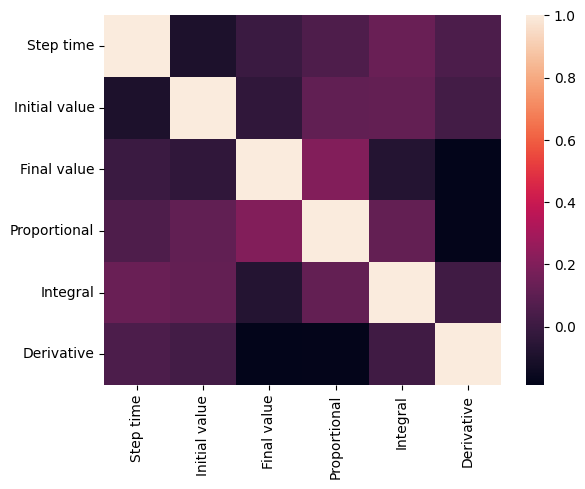

In [ ]:
sns.heatmap(X_train.corr())

<h2>Implement SVM Model</h2>

<h3>Use GridSearch to find the best values of Kernel, C, gamma</h3>

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],          # Regularization
    'gamma': ['scale', 0.1],  # Kernel width
    'kernel': ['rbf']                 # Keep RBF for this tuning
}

scoring = {'F1': 'f1_weighted'}
svm = SVC(random_state=42)

# 5-fold CV with F1 optimization
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring=scoring,
    refit='F1',       # Refit best model on F1-score
    cv=5,             # Stratified by default
    n_jobs=-1,        # Use all CPU cores
    verbose=1,
)

grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best F1-score:", grid_search.best_score_)

# Get best model
best_svm = grid_search.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best F1-score: 0.9293584577330707


<h3>Implement the SVM Model with ensembling techniques (BalancedBaggingClassifier)</h3>

In [ ]:
from sklearn.svm import SVC
from imblearn.ensemble import BalancedBaggingClassifier

model = SVC(kernel='rbf', C=1, gamma=0.1, random_state=42)

bbc = BalancedBaggingClassifier(
    estimator=model,
    sampling_strategy='auto',
    n_estimators=10,
    random_state=42
)
bbc.fit(X_train_scaled, y_train)

BalancedBaggingClassifier(estimator=SVC(C=1, gamma=0.1, random_state=42),
                          random_state=42)

<h2>Measure Accuracy of the Model</h2>

<h4>Precision - What fraction of predicted positives are actually correct i.e. "How many selected items are correct?"</h4>

<h6>High precision = Few false positives.</h6>

<h6>Low precision = Many false alarms.
</h6>

<h4>Recall - What fraction of actual positives did the model catch i.e. "How many correct items were selected?"</h4>

<h6>High recall = Few false negatives.</h6>

<h6>Low recall = Missed many true positives</h6>

<h4>F1 Score = Harmonic mean of precision and recall (balances both)</h4>

<h4>Support = Number of actual samples per class in the test set</h4>

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = bbc.predict(X_test_scaled)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Detailed report (precision, recall, F1)
print(classification_report(y_test, y_pred))

# Confusion matrix
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9310344827586207
              precision    recall  f1-score   support

           0       1.00      0.88      0.94        17
           1       0.86      1.00      0.92        12

    accuracy                           0.93        29
   macro avg       0.93      0.94      0.93        29
weighted avg       0.94      0.93      0.93        29

[[15  2]
 [ 0 12]]


<h2>Perform K-Fold Cross Validation, CV=5</h2>

<h3>The model is trained on 4 parts and tested on the remaining 1</h3>

<h3>This is repeated 5 times, with a different test set each time</h3>

<h3>Each run produces a performance score (here, the weighted F1-score)</h3>

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(bbc, X_train_scaled, y_train, cv=5, scoring='f1_weighted')  # Or 'roc_auc'

print("Mean F1-score:", scores.mean())

Mean F1-score: 0.9293584577330707


<h2>Show the Decision Boundary</h2>

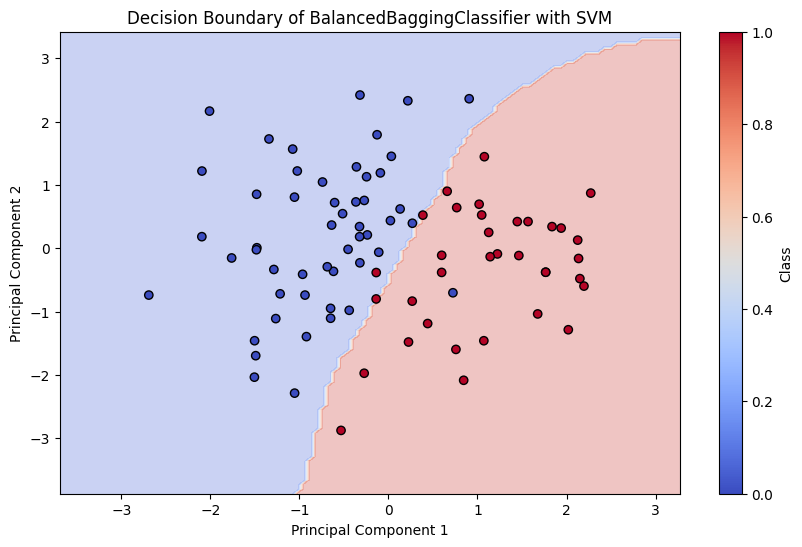

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions

# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train_scaled)

# Train a new BalancedBaggingClassifier on 2D data
# (Note: We must retrain because PCA changed the features)
bbc_2d = BalancedBaggingClassifier(
    estimator=SVC(kernel='rbf', C=1, gamma=0.1, random_state=42),
    sampling_strategy='auto',
    n_estimators=10,
    random_state=42
)
bbc_2d.fit(X_train_2d, y_train)

# Create a mesh grid for the decision boundary
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Get predictions for each point in the mesh grid
Z = bbc_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

# Plot the training points
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train,
            cmap='coolwarm', edgecolors='k')

# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundary of BalancedBaggingClassifier with SVM')
plt.colorbar(label='Class')
plt.show()